In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# System libraries
import os
import sys
import h5py
import configparser
import json

#Standard libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rasterio as rs
import rioxarray as rx

#For geometries
import shapely
from shapely import box, LineString, MultiLineString, Point, Polygon, LinearRing
from shapely.geometry.polygon import orient

#For REMA
from rasterio import plot
from rasterio.mask import mask
from rasterio.features import rasterize

#Datetime
from datetime import datetime
from datetime import timedelta
from datetime import timezone
from dateutil.relativedelta import relativedelta
import time

#For plotting, ticking, and line collection
from matplotlib import cm 
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LightSource, LinearSegmentedColormap
from matplotlib.lines import Line2D
import cmcrameri.cm as cmc
import contextily as cx
import earthpy.spatial as es
# for legend
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerTuple

#For error handling
import shutil
import traceback

#For raster
from rasterio.transform import from_origin

# not in use 
from ipyleaflet import Map, basemaps, Polyline, GeoData, LayersControl
from rasterio import warp
from rasterio.crs import CRS

In [2]:
where = '/Volumes/nox2/Chance/its_live/'
file_ux = f'{where}/ITS_LIVE_velocity_120m_RGI19A_2019_v02_vx.tif'
file_uy = f'{where}/ITS_LIVE_velocity_120m_RGI19A_2019_v02_vy.tif'

crs_antarctica = 'EPSG:3031'
crs_latlon = 'EPSG:4326'

dsux = rx.open_rasterio(file_ux)  # Open with rioxarray 
tr = dsux.rio.transform()

dsux = xr.open_dataset(file_ux)
dsux.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
dsux.rio.write_crs(crs_antarctica, inplace=True)

dsuy = xr.open_dataset(file_uy)
dsuy.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
dsuy.rio.write_crs(crs_antarctica, inplace=True)

#u=xr.merge([dsux.rename_vars({'band_data': 'ux'}), dsuy.rename_vars({'band_data': 'uy'})]).sel(band=1).drop_vars(['spatial_ref', 'band'])
u=xr.merge([dsux.rename_vars({'vx': 'ux'}), dsuy.rename_vars({'vy': 'uy'})]).sel(band=1).drop_vars(['band'])
u.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True)
u.rio.write_crs(crs_antarctica, inplace=True);



In [35]:
np.nanmax(np.ndarray.flatten(E_p[0, 0, :, :]-E_p[1, 1, :, :]))

-1.738009423686267e-06

In [13]:
shape = 'shapes/scripps_antarctic_polygons_CR.shp'
#roi = 'shapes/I-Ipp_larsenc_mélange.shp'

gdf = gpd.read_file(shape).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)
#gdf = gdf[gdf.Regions=='East']

#roi_gdf = gpd.read_file(roi).set_crs(crs_latlon, allow_override=True).to_crs(crs_antarctica)

In [7]:
gdf

,geometry
0,"POLYGON ((-753955.787 1039049.085, -753910.327..."
1,"POLYGON ((281566.738 2153904.442, 281913.219 2..."
2,"POLYGON ((-362950 2060149.726, -362950 2060200..."
3,"POLYGON ((-410075 2027325, -410075 2027450, -4..."
4,"POLYGON ((-25225.946 2006836.434, -25436.445 2..."
...,...
1054,"POLYGON ((-2312233.141 2296240.565, -2312370.9..."
1055,"POLYGON ((-2305185.994 2301737.597, -2305042.6..."
1056,"POLYGON ((-2278497.471 2317588.723, -2278497.6..."
1057,"POLYGON ((-813134.779 422430.778, -813166.565 ..."


In [8]:
x, y = u.x.values, u.y.values

u_0_0 = u.ux.differentiate(coord='x').values
u_0_1 = u.ux.differentiate(coord='y').values
u_1_0 = u.uy.differentiate(coord='x').values
u_1_1 = u.uy.differentiate(coord='y').values

# numpy arrays are denoted with capitals
# xarrays in lowercase with indices in the name

# Jacobian
U = np.array([[u_0_0, u_0_1], [u_1_0, u_1_1]])
# Pauli z matrix
pauli_3 = np.array([[1, 0], [0 , -1]])
# strain tensor
E = 0.5*(U + U.transpose(1, 0, 2, 3))
# 2D Rotation matrix and a function
R = lambda theta: np.array([[np.cos(theta*np.pi/180), -np.sin(theta*np.pi/180)], [np.sin(theta*np.pi/180), np.cos(theta*np.pi/180)]])
def rotate(T, theta): return np.einsum('ki,klmn,lj', R(theta), T, R(theta))
# Rotated strain tensor E'
E_prime = lambda theta: rotate(E, theta)

# strain tensor in x, y reference frame
e_ij = xr.DataArray(E_prime(0).transpose(3, 2, 0, 1), coords={'x': x, 'y': y}, dims=['x', 'y', 'i', 'j'])
# Principal strain rates
# mohr circle radius
r = np.sqrt((0.5*np.einsum('ij,ijmn', pauli_3, E))**2 + E[0, 1, :, :]**2)
# mohr circle center
c = 0.5*np.einsum('iimn', E)
# principle strain rates
E_p = np.einsum('imn,ij->ijmn', c - np.einsum('mn,ii->imn', r, pauli_3), np.identity(2))
'''
E_d = E_p - (1/2)*np.einsum('iimn', E_p)
e_ij_p = xr.DataArray(E_p.transpose(2, 3, 0, 1), coords={'y': y, 'x': x}, dims=['y', 'x', 'i', 'j'])
e_ij_d = xr.DataArray(E_d.transpose(2, 3, 0, 1), coords={'y': y, 'x': x}, dims=['y', 'x', 'i', 'j'])
# angles from EPSG:3031 reference frame
theta_p = xr.DataArray(0.5*np.arctan2(E[0, 1, :, :], (np.einsum('ij,ijmn', pauli_3, E))), coords={'y': y, 'x': x})
u_mag = xr.DataArray(np.sqrt(u.ux**2 + u.uy**2), coords={'y': y, 'x': x})

# Get flow direction from velocities
theta_u = np.arctan2(u.uy, u.ux)
# Rotated train tensor DataArray
E_u = np.einsum('kimn,klmn,ljmn->ijmn', R(theta_u), E, R(theta_u))
e_ij_u = xr.DataArray(E_u.transpose(2, 3, 0, 1), coords={'y': y, 'x': x}, dims=['y', 'x', 'i', 'j'])

# set up with rio for plottting
e_ij_p.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True);
e_ij_p.rio.write_crs(crs_antarctica, inplace=True);
e_ij_d.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True);
e_ij_d.rio.write_crs(crs_antarctica, inplace=True);
e_ij_u.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True);
e_ij_u.rio.write_crs(crs_antarctica, inplace=True);
u_mag.rio.set_spatial_dims(x_dim='y', y_dim='x', inplace=True);
u_mag.rio.write_crs(crs_antarctica, inplace=True);
'''

In [12]:
E_p.shape

(2, 2, 4609, 5311)

0.0

NameError: name 'im3' is not defined

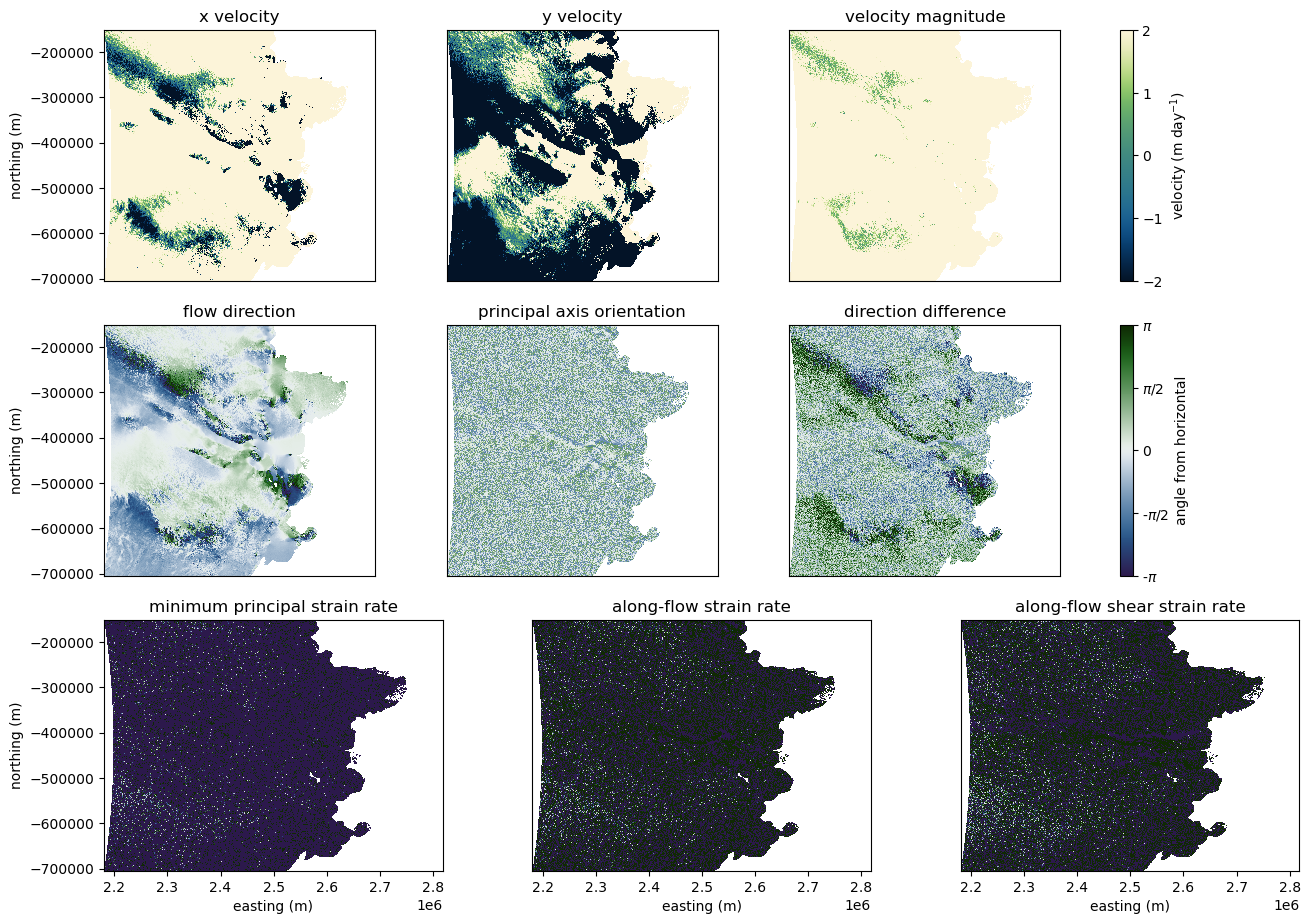

In [9]:
vmin = -2
vmax = 2

fig, axes = plt.subplots(3, 3, figsize=[13, 9])
axes = list(np.reshape(axes, [9]))
cax=[]
for ax in axes: cax.append(ax.inset_axes([1.03, 0, 0.1, 1], transform=ax.transAxes))
fig.tight_layout()

ax = axes[0]
u.ux.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[0]})
ax.set_title('x velocity')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('northing (m)')
ax = axes[1]
u.uy.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[1]})
ax.set_title('y velocity')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')
ax = axes[2]
ax.set_xlabel('')
im1 = u_mag.plot(ax=ax, cmap=cmc.navia, vmin=vmin, vmax=vmax, cbar_kwargs={'cax': cax[2]})
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_title('velocity magnitude')

ax = axes[3]
theta_u.plot(ax=ax, cmap=cmc.cork, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[3]})
ax.set_title('flow direction')
ax.set_xticks([])
ax.set_xlabel('')
ax.set_ylabel('northing (m)')
ax = axes[4]
xr.apply_ufunc(lambda x: x, theta_p).plot(ax=ax, cmap=cmc.cork, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[4]})
ax.set_title('principal axis orientation')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')
ax = axes[5]
diff = theta_p - theta_u
im2 = diff.plot(ax=ax, cmap=cmc.cork, vmin=-3.14, vmax=3.14, cbar_kwargs={'cax': cax[5]})
ax.set_title('direction difference')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xticks([])
ax.set_xlabel('')

ax = axes[6]
(e_ij_p.sel(i=0, j=0)*1e3).plot(ax=ax, cmap=cmc.cork, vmin=vmin/10, vmax=vmax/10, cbar_kwargs={'cax': cax[8]})
ax.set_title('minimum principal strain rate')
ax.set_ylabel('northing (m)')
ax.set_xlabel('easting (m)')
ax = axes[7]
(e_ij_u.sel(i=0, j=0)*1e3).plot(ax=ax, cmap=cmc.cork, vmin=vmin/10, vmax=vmax/10, cbar_kwargs={'cax': cax[6]})
ax.set_title('along-flow strain rate')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('easting (m)')
ax = axes[8]
(e_ij_u.sel(i=0, j=1)*1e3).plot(ax=ax, cmap=cmc.cork, vmin=vmin/10, vmax=vmax/10, cbar_kwargs={'cax': cax[7]})
ax.set_title('along-flow shear strain rate')
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('easting (m)')

# remove colorbars to build new ones
for c in cax: c.remove()
cb1 = fig.colorbar(im1, ax=axes[0:3], label='velocity (m day$^{-1}$)')
cb1.set_ticks([-2, -1, 0, 1, 2])
cb2 = fig.colorbar(im2, ax=axes[3:6], label='angle from horizontal')
cb2.set_ticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
cb2.set_ticklabels(['-$\\pi$', '-$\\pi$/2', 0, '$\\pi$/2', '$\\pi$']);
cb3 = fig.colorbar(im3, ax=axes[6:9], label='strain rate (mm m$^{-1}$s$^{-1}$)')
cb3.set_ticks([-0.2, -0.1, 0, 0.1, 0.2])

#fig.savefig('/Users/ccroberts/Desktop/Strain.pdf', dpi=500, box_inches='tight')



In [36]:
height, width = E_p[0, 0, :, :].shape  # Ensure these are integers

meta = {
    "driver": "GTiff",
    "height": int(height),
    "width": int(width),
    "count": 1,  # Assuming a single-band raster
    "dtype": E_p.dtype,
    "crs": "EPSG:3031",  # Replace with actual CRS if available
    "transform": tr,
}

with rs.open("/Users/ccroberts/Desktop/its_live_2019_e1.tif", "w", **meta) as dst:
    dst.write(E_p[1, 1, :, :], 1)

In [20]:
E_p

array([[[[-0.00165768, -0.00517968, -0.0043547 , ...,         nan,
                  nan,         nan],
         [-0.00732197, -0.003533  , -0.00225647, ...,         nan,
                  nan,         nan],
         [-0.00508951, -0.00101436, -0.00306865, ...,         nan,
                  nan,         nan],
         ...,
         [-0.00049876, -0.00117342, -0.00128459, ...,         nan,
                  nan,         nan],
         [-0.00246307, -0.0020493 , -0.00154251, ...,         nan,
                  nan,         nan],
         [-0.00202612, -0.00116671, -0.00195673, ...,         nan,
                  nan,         nan]],

        [[ 0.        ,  0.        ,  0.        , ...,         nan,
                  nan,         nan],
         [ 0.        ,  0.        ,  0.        , ...,         nan,
                  nan,         nan],
         [ 0.        ,  0.        ,  0.        , ...,         nan,
                  nan,         nan],
         ...,
         [ 0.        ,  0.        